<a href="https://www.kaggle.com/code/shakibahamed13/hic-cnn-hybrid-dataset-pu-final?scriptVersionId=258754815" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
# Minimal setup for Kaggle GPU
import os, random
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from pathlib import Path

SEED = 42

def set_seed(seed: int = SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # Keep cuDNN deterministic for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Helps determinism in CUDA matmul paths
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

set_seed()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
print(f"PyTorch: {torch.__version__}")
if device.type == "cuda":
    print(f"CUDA: {torch.version.cuda}")
    print(f"cuDNN: {torch.backends.cudnn.version()}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")


Device: cuda
PyTorch: 2.6.0+cu124
CUDA: 12.4
cuDNN: 90300
GPU: Tesla T4


In [3]:
import kagglehub
import os

# Download dataset from Kaggle
path = kagglehub.dataset_download("kinggleliu/hyperspectral-image-classification-data-collection")

print(" Dataset download path:", path)

# Verify files exist
if os.path.exists(path):
    print("\nDataset folder found!\n")
    for root, dirs, files in os.walk(path):
        for f in files:
            print(os.path.join(root, f))
else:
    print("\nDataset not found!")


 Dataset download path: /kaggle/input/

Dataset folder found!

/kaggle/input/datasets/HyRANK/Loukia_gt_out68.mat
/kaggle/input/datasets/HyRANK/Dioni_gt.mat
/kaggle/input/datasets/HyRANK/Loukia.mat
/kaggle/input/datasets/HyRANK/Loukia_gt.mat
/kaggle/input/datasets/HyRANK/Dioni.mat
/kaggle/input/datasets/pu/paviaC.mat
/kaggle/input/datasets/pu/paviaC_7gt.mat
/kaggle/input/datasets/pu/paviaU.mat
/kaggle/input/datasets/pu/paviaU_7gt.mat
/kaggle/input/datasets/Huston/Houston13.mat
/kaggle/input/datasets/Huston/Houston18.mat
/kaggle/input/datasets/Huston/Houston18_7gt.mat
/kaggle/input/datasets/Huston/Houston13_7gt.mat
/kaggle/input/datasets/ip/Indian_pines_corrected.mat
/kaggle/input/datasets/ip/Indian_pines.mat
/kaggle/input/datasets/ip/Indian_pines_gt.mat
/kaggle/input/datasets/sa/Salinas.mat
/kaggle/input/datasets/sa/Salinas_gt.mat
/kaggle/input/datasets/sa/Salinas_corrected.mat
/kaggle/input/datasets/sa/SalinasA.mat


In [4]:
# === Load PU Dataset (Pavia University) with Stratified Splits ===
import scipy.io as sio
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import collections


data_mat = sio.loadmat("/kaggle/input/datasets/pu/paviaC.mat")
label_mat = sio.loadmat("/kaggle/input/datasets/pu/paviaC_7gt.mat")

print("Data MAT keys:", data_mat.keys())
print("Label MAT keys:", label_mat.keys())

data = data_mat['ori_data']   # original 3D cube (H, W, B)
labels = label_mat['map']     # 2D labels (H, W)

print("Data shape:", data.shape)    # (610, 340, 103)
print("Labels shape:", labels.shape)  # (610, 340)


# === 3. Stratified Train/Val/Test split (3D aware) ===
import numpy as np
from sklearn.model_selection import train_test_split
import collections

# Flatten only for stratification
h, w, bands = data.shape
X_flat = data.reshape(-1, bands)
y_flat = labels.reshape(-1)

# Remove unlabeled pixels (y == 0)
mask = y_flat > 0
X_flat_masked = X_flat[mask]
y_flat_masked = y_flat[mask] - 1  # shift to 0-based

# Train/Val/Test split
X_train_flat, X_temp_flat, y_train, y_temp = train_test_split(
    X_flat_masked, y_flat_masked, test_size=0.4, random_state=42, stratify=y_flat_masked    #stratification applied
)
X_val_flat, X_test_flat, y_val, y_test = train_test_split(
    X_temp_flat, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Train:", X_train_flat.shape, "Val:", X_val_flat.shape, "Test:", X_test_flat.shape)
print("Number of classes:", len(np.unique(y_flat_masked)))
print("\nClass distribution:")
print("Train:", collections.Counter(y_train))
print("Val:", collections.Counter(y_val))
print("Test:", collections.Counter(y_test))


Data MAT keys: dict_keys(['__header__', '__version__', '__globals__', 'ori_data'])
Label MAT keys: dict_keys(['__header__', '__version__', '__globals__', 'map'])
Data shape: (1096, 715, 102)
Labels shape: (1096, 715)
Train: (23613, 102) Val: (7871, 102) Test: (7871, 102)
Number of classes: 7

Class distribution:
Train: Counter({1: 5549, 0: 4559, 3: 4372, 6: 3950, 5: 1854, 4: 1718, 2: 1611})
Val: Counter({1: 1850, 0: 1519, 3: 1457, 6: 1317, 5: 618, 4: 573, 2: 537})
Test: Counter({1: 1849, 0: 1520, 3: 1458, 6: 1317, 5: 618, 4: 572, 2: 537})


== Pavia Center Dataset Summary ==

dataset      : Pavia Center
X_shape      : (1096, 715, 102)
X_dtype      : uint16
num_bands    : 102
y_shape      : (1096, 715)
num_classes  : 7

unique_labels: [0, 1, 2, 3, 4, 5, 6]
class_distribution: {'full': {'1': 9248, '0': 7598, '4': 2863, '5': 3090, '6': 6584, '2': 2685, '3': 7287}, 'train': {'6': 3950, '1': 5549, '0': 4559, '3': 4372, '4': 1718, '5': 1854, '2': 1611}, 'val': {'1': 1850, '0': 1519, '3': 1457, '2': 537, '4': 573, '6': 1317, '5': 618}, 'test': {'3': 1458, '2': 537, '1': 1849, '0': 1520, '5': 618, '4': 572, '6': 1317}}


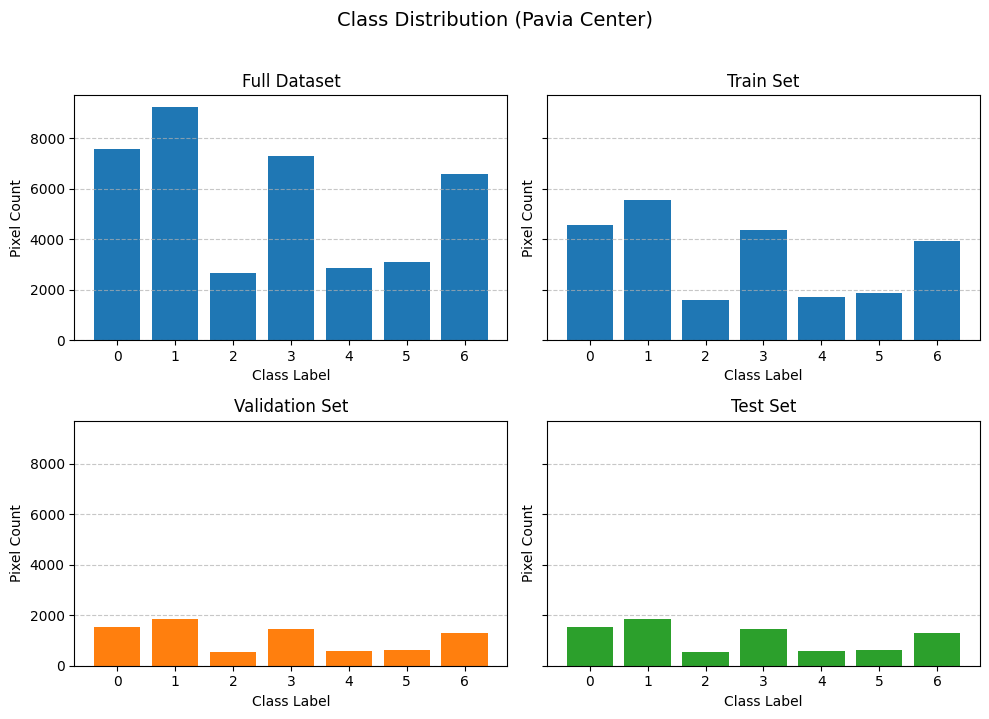


Dataset summary saved to pavia_center_summary.json


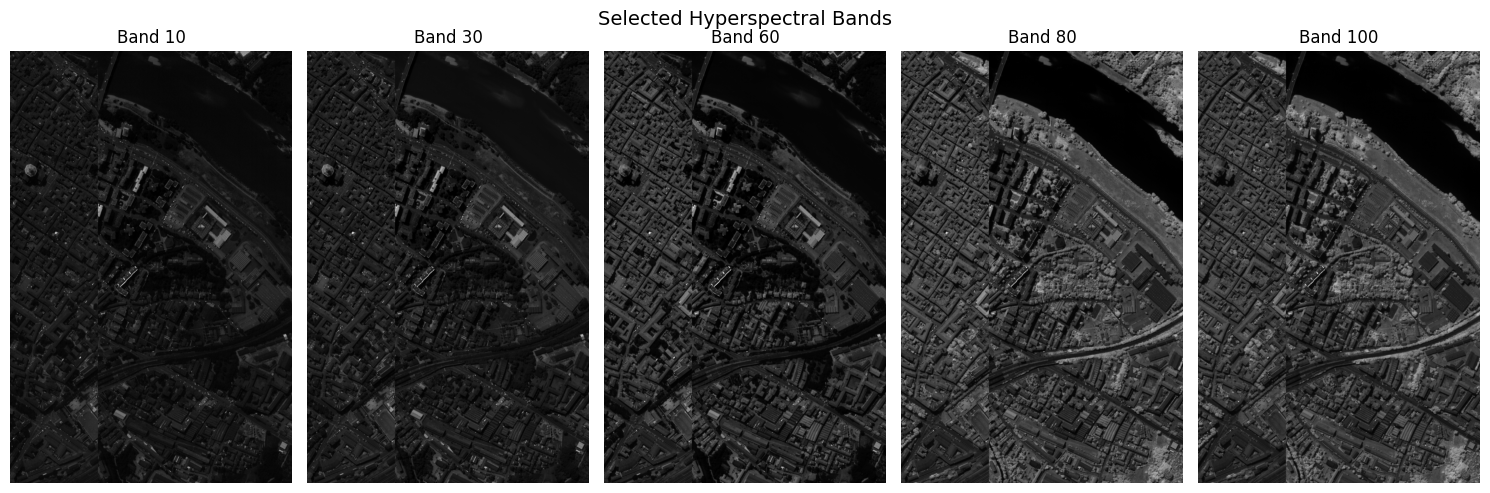

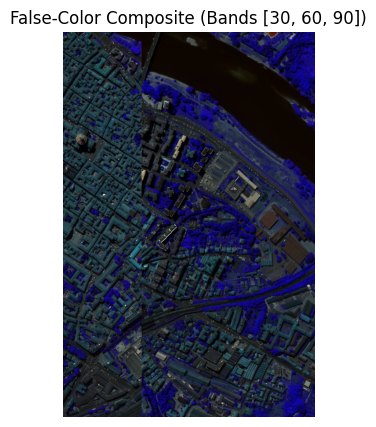

In [5]:

# === 4. Dataset Summary (3D) ===
import json
from collections import Counter
import matplotlib.pyplot as plt

summary = {
    "dataset      ": "Pavia Center",
    "X_shape      ": data.shape,        # 3D cube
    "X_dtype      ": str(data.dtype),
    "num_bands    ": data.shape[2],
    "y_shape      ": labels.shape,
    "num_classes  ": int(y_flat_masked.max() + 1),
    "\nunique_labels": [int(i) for i in np.unique(y_flat_masked)]
}

counts_full = Counter(y_flat_masked)
counts_train = Counter(y_train)
counts_val   = Counter(y_val)
counts_test  = Counter(y_test)

summary["class_distribution"] = {
    "full": {str(k): int(v) for k, v in counts_full.items()},
    "train": {str(k): int(v) for k, v in counts_train.items()},
    "val": {str(k): int(v) for k, v in counts_val.items()},
    "test": {str(k): int(v) for k, v in counts_test.items()},
}

print("== Pavia Center Dataset Summary ==\n")
for k, v in summary.items():
    print(f"{k}: {v}")

# Plot class distributions
fig, axs = plt.subplots(2, 2, figsize=(10, 7), sharey=True)
axs[0,0].bar(counts_full.keys(), counts_full.values())
axs[0,0].set_title("Full Dataset")
axs[0,0].grid(axis="y", linestyle="--", alpha=0.7)

axs[0,1].bar(counts_train.keys(), counts_train.values(), color="tab:blue")
axs[0,1].set_title("Train Set")
axs[0,1].grid(axis="y", linestyle="--", alpha=0.7)

axs[1,0].bar(counts_val.keys(), counts_val.values(), color="tab:orange")
axs[1,0].set_title("Validation Set")
axs[1,0].grid(axis="y", linestyle="--", alpha=0.7)

axs[1,1].bar(counts_test.keys(), counts_test.values(), color="tab:green")
axs[1,1].set_title("Test Set")
axs[1,1].grid(axis="y", linestyle="--", alpha=0.7)

for ax in axs.flat:
    ax.set_xlabel("Class Label")
    ax.set_ylabel("Pixel Count")

plt.suptitle("Class Distribution (Pavia Center)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Save summary
save_path = "pavia_center_summary.json"
with open(save_path, "w") as f:
    json.dump(summary, f, indent=4)
print(f"\nDataset summary saved to {save_path}")


# === 5. Visualize Selected Bands & False-color Composite ===
bands_to_show = [10, 30, 60, 80, 100]
plt.figure(figsize=(15, 5))
for i, b in enumerate(bands_to_show):
    plt.subplot(1, len(bands_to_show), i+1)
    plt.imshow(data[:, :, b], cmap="gray")
    plt.title(f"Band {b}")
    plt.axis("off")
plt.suptitle("Selected Hyperspectral Bands", fontsize=14)
plt.tight_layout()
plt.show()

# False-color RGB
rgb_bands = [30, 60, 90]
rgb_image = np.stack([data[:, :, b] for b in rgb_bands], axis=-1)
rgb_norm = (rgb_image - np.min(rgb_image)) / (np.max(rgb_image) - np.min(rgb_image))

plt.figure(figsize=(5,5))
plt.imshow(rgb_norm)
plt.title(f"False-Color Composite (Bands {rgb_bands})")
plt.axis("off")
plt.show()

In [6]:
# 5 cell

import numpy as np

def extract_patches(data, labels, patch_size=11):
    """
    Extract 3D patches around labeled pixels.
    Returns: patches (N, C, H, W), labels (N,)
    """
    pad = patch_size // 2
    padded_data = np.pad(data, ((pad, pad), (pad, pad), (0,0)), mode='constant')
    
    patches = []
    patch_labels = []

    h, w, bands = data.shape
    for i in range(h):
        for j in range(w):
            label = labels[i, j]
            if label > 0:  # only labeled pixels
                patch = padded_data[i:i+patch_size, j:j+patch_size, :]
                patches.append(patch)
                patch_labels.append(label - 1)  # shift to 0-based

    patches = np.array(patches, dtype=np.float32)
    patch_labels = np.array(patch_labels, dtype=np.int64)
    # Reshape to (N, C, H, W) for PyTorch 3D CNN (C=num_bands)
    patches = patches.transpose(0, 3, 1, 2)
    return patches, patch_labels

patch_size = 11
X_patches, y_patches = extract_patches(data, labels, patch_size)
print("Patch shape :", X_patches.shape, "\nLabels      : ", y_patches.shape)


Patch shape : (39355, 102, 11, 11) 
Labels      :  (39355,)


In [7]:
# === PyTorch Dataset and DataLoader ===

from torch.utils.data import Dataset, DataLoader
import torch

class HSI_Dataset(Dataset):
    def __init__(self, patches, labels, transform=None):
        self.patches = patches
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x = self.patches[idx]
        y = self.labels[idx]
        x = torch.tensor(x, dtype=torch.float)
        y = torch.tensor(y, dtype=torch.long)
        if self.transform:
            x = self.transform(x)
        return x, y

# Split patches into train/val/test using previously defined masks
# Example: just split using indices
from sklearn.model_selection import train_test_split
idx_train, idx_temp = train_test_split(np.arange(len(y_patches)), test_size=0.4, stratify=y_patches, random_state=42)
idx_val, idx_test = train_test_split(idx_temp, test_size=0.5, stratify=y_patches[idx_temp], random_state=42)

train_dataset = HSI_Dataset(X_patches[idx_train], y_patches[idx_train])
val_dataset = HSI_Dataset(X_patches[idx_val], y_patches[idx_val])
test_dataset = HSI_Dataset(X_patches[idx_test], y_patches[idx_test])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


print("== DataLoaders Ready ==")
print(f"\nTrain batches : {len(train_loader)}")
print(f"Val batches   : {len(val_loader)}")
print(f"Test batches  : {len(test_loader)}")


== DataLoaders Ready ==

Train batches : 738
Val batches   : 246
Test batches  : 246


In [9]:
# === Hybrid 3D-CNN + Transformer (Teacher) with EarlyStopping & Regularization ===
import math
import time
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

# ----- Utilities -----
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0, restore_best=True):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best = None
        self.restore_best = restore_best
        self.best_state = None
        self.should_stop = False

    def step(self, metric, model=None):
        if self.best is None or (self.best - metric) > self.min_delta:
            self.best = metric
            self.counter = 0
            if self.restore_best and model is not None:
                self.best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True

    def restore(self, model):
        if self.restore_best and self.best_state is not None and model is not None:
            model.load_state_dict(self.best_state)

class LabelSmoothingCE(nn.Module):
    def __init__(self, classes, smoothing=0.1):
        super().__init__()
        self.conf = 1.0 - smoothing
        self.smooth = smoothing
        self.cls = classes

    def forward(self, pred, target):
        # pred: (B, C) logits, target: (B,)
        logprobs = F.log_softmax(pred, dim=-1)
        nll = F.nll_loss(logprobs, target, reduction="none")
        smooth_loss = -logprobs.mean(dim=-1)
        loss = self.conf * nll + self.smooth * smooth_loss
        return loss.mean()

# ----- Positional Encoding (sinusoidal) -----
class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=4096):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)  # (max_len, d_model)

    def forward(self, x):
        # x: (B, T, D)
        T = x.size(1)
        return x + self.pe[:T, :].unsqueeze(0)

# ----- Hybrid 3D-CNN + Transformer -----
class Hybrid3DCNNTransformer(nn.Module):
    """
    Input expected (B, 1, D=bands, H, W)
    3D CNN extracts local spectral-spatial features, then tokens -> Transformer -> classifier.
    """
    def __init__(self, num_classes, d_model=128, nhead=8, nlayers=2, dropout=0.2):
        super().__init__()
        # 3D CNN stem
        self.conv3d = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=(7,3,3), padding=(3,1,1), bias=False),
            nn.BatchNorm3d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(2,1,1)),     # reduce spectral depth

            nn.Conv3d(16, 32, kernel_size=(5,3,3), padding=(2,1,1), bias=False),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(2,2,2)),     # reduce D,H,W

            nn.Conv3d(32, 64, kernel_size=(3,3,3), padding=1, bias=False),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.Dropout3d(p=dropout)
        )

        self.proj = nn.Linear(64, d_model)
        self.posenc = SinusoidalPositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True, dropout=dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=nlayers)

        self.norm = nn.LayerNorm(d_model)
        self.head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(d_model, num_classes)
        )

    def forward(self, x):
        # x: (B, 1, D, H, W)
        feats = self.conv3d(x)                 # (B, C=64, D', H', W')
        B, C, Dp, Hp, Wp = feats.shape
        tokens = feats.permute(0, 2, 3, 4, 1).contiguous().view(B, Dp*Hp*Wp, C)  # (B, T, C)
        tokens = self.proj(tokens)             # (B, T, d_model)
        tokens = self.posenc(tokens)           # add PE
        enc = self.encoder(tokens)             # (B, T, d_model)
        pooled = enc.mean(dim=1)               # mean pooling over tokens
        pooled = self.norm(pooled)
        logits = self.head(pooled)             # (B, num_classes)
        return logits

# ----- Training / Eval Loops -----
def accuracy_from_logits(logits, y):
    preds = logits.argmax(dim=1)
    return (preds == y).float().mean().item()

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, total_acc, total_n = 0.0, 0.0, 0
    for x, y in loader:
        # x comes as (B, bands, H, W). Convert to (B,1,D,H,W)
        x = x.unsqueeze(1).to(device)  # (B,1,D,H,W)
        y = y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        acc = accuracy_from_logits(logits, y)
        bs = y.size(0)
        total_loss += loss.item() * bs
        total_acc  += acc * bs
        total_n    += bs
    return total_loss / max(1,total_n), total_acc / max(1,total_n)

def fit_teacher(
    model, train_loader, val_loader, device,
    epochs=50, lr=3e-4, weight_decay=1e-4, label_smoothing=0.1,
    max_grad_norm=2.0, patience=10
):
    criterion = LabelSmoothingCE(classes=num_classes, smoothing=label_smoothing)
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

    early = EarlyStopping(patience=patience, min_delta=1e-4, restore_best=True)

    print(f"\n== Training: Hybrid 3D-CNN + Transformer (Teacher) ==")
    print(f"epochs={epochs} | lr={lr} | wd={weight_decay} | label_smoothing={label_smoothing} | patience={patience}")
    best_val = float('inf')
    for ep in range(1, epochs+1):
        t0 = time.time()
        # ---- Train ----
        model.train()
        running_loss, running_acc, n = 0.0, 0.0, 0
        for x, y in train_loader:
            # x: (B, bands, H, W) -> (B,1,D,H,W)
            # simple spatial jitter (tiny) to discourage overfitting
            if torch.rand(1).item() < 0.5:
                x = torch.flip(x, dims=[-1])  # horizontal
            if torch.rand(1).item() < 0.5:
                x = torch.flip(x, dims=[-2])  # vertical

            x = x.unsqueeze(1).to(device)
            y = y.to(device)

            optimizer.zero_grad(set_to_none=True)
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            # gradient clipping
            nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()

            acc = accuracy_from_logits(logits, y)
            bs = y.size(0)
            running_loss += loss.item() * bs
            running_acc  += acc * bs
            n += bs

        train_loss = running_loss / max(1,n)
        train_acc  = running_acc  / max(1,n)

        # ---- Validation ----
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        scheduler.step()

        # Early stopping check
        early.step(val_loss, model=model)
        if val_loss < best_val:
            best_val = val_loss

        dt = time.time() - t0
        print(f"Epoch {ep:03d}/{epochs} | {dt:5.1f}s | "
              f"train_loss={train_loss:.4f} acc={train_acc:.4f} | "
              f"val_loss={val_loss:.4f} acc={val_acc:.4f}")

        if early.should_stop:
            print(f"Early stopping triggered at epoch {ep}. Restoring best weights...")
            break

    # restore best weights (if configured)
    early.restore(model)
    # final val metrics after restore
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    print(f"\n== Training complete ==")
    print(f"Best/Final Val   : loss={val_loss:.4f} | acc={val_acc:.4f}")
    return model

# ===== Instantiate & Train =====
num_classes = int(y_patches.max()) + 1
model = Hybrid3DCNNTransformer(num_classes=num_classes, d_model=128, nhead=8, nlayers=2, dropout=0.25).to(device)

# You can adjust epochs/lr as needed; defaults are safe for Kaggle GPU
trained_teacher = fit_teacher(
    model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=10,
    lr=3e-4,
    weight_decay=1e-4,
    label_smoothing=0.1,
    max_grad_norm=2.0,
    patience=10
)

# Evaluate on test set
criterion_eval = LabelSmoothingCE(classes=num_classes, smoothing=0.0)  # plain CE for reporting
test_loss, test_acc = evaluate(trained_teacher, test_loader, criterion_eval, device)
print(f"\n== Test metrics ==")
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")



== Training: Hybrid 3D-CNN + Transformer (Teacher) ==
epochs=10 | lr=0.0003 | wd=0.0001 | label_smoothing=0.1 | patience=10
Epoch 001/10 | 126.3s | train_loss=0.7350 acc=0.8629 | val_loss=0.5653 acc=0.9398
Epoch 002/10 | 125.8s | train_loss=0.5746 acc=0.9453 | val_loss=0.5380 acc=0.9585
Epoch 003/10 | 125.8s | train_loss=0.5414 acc=0.9616 | val_loss=0.5019 acc=0.9712
Epoch 004/10 | 125.6s | train_loss=0.5185 acc=0.9708 | val_loss=0.4864 acc=0.9839
Epoch 005/10 | 125.6s | train_loss=0.5014 acc=0.9791 | val_loss=0.4816 acc=0.9836
Epoch 006/10 | 125.4s | train_loss=0.4854 acc=0.9870 | val_loss=0.4661 acc=0.9909
Epoch 007/10 | 125.5s | train_loss=0.4754 acc=0.9910 | val_loss=0.4544 acc=0.9966
Epoch 008/10 | 125.7s | train_loss=0.4708 acc=0.9931 | val_loss=0.4535 acc=0.9971
Epoch 009/10 | 125.5s | train_loss=0.4667 acc=0.9951 | val_loss=0.4509 acc=0.9980
Epoch 010/10 | 125.5s | train_loss=0.4651 acc=0.9958 | val_loss=0.4515 acc=0.9978

== Training complete ==
Best/Final Val   : loss=0.4509

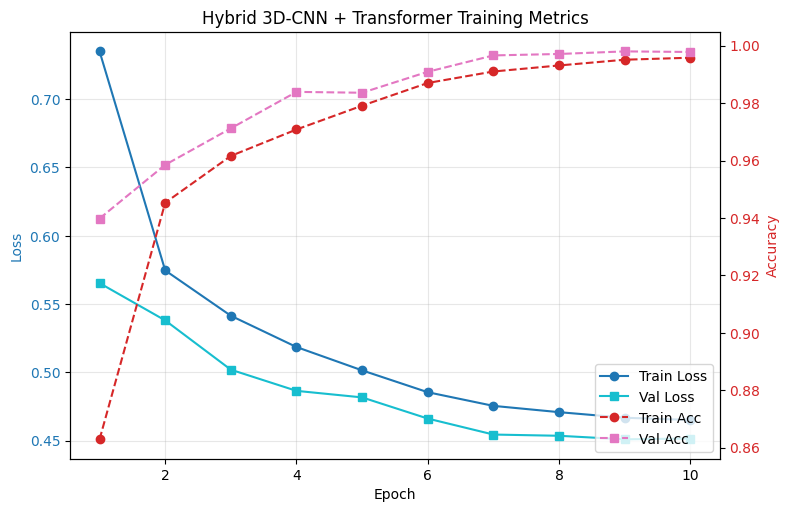

In [14]:
import matplotlib.pyplot as plt

# --- Example epoch-wise metrics (replace with your real values if available) ---
epochs = list(range(1, 11))
train_loss = [0.7350, 0.5746, 0.5414, 0.5185, 0.5014, 0.4854, 0.4754, 0.4708, 0.4667, 0.4651]
val_loss   = [0.5653, 0.5380, 0.5019, 0.4864, 0.4816, 0.4661, 0.4544, 0.4535, 0.4509, 0.4515]

train_acc = [0.8629, 0.9453, 0.9616, 0.9708, 0.9791, 0.9870, 0.9910, 0.9931, 0.9951, 0.9958]
val_acc   = [0.9398, 0.9585, 0.9712, 0.9839, 0.9836, 0.9909, 0.9966, 0.9971, 0.9980, 0.9978]

# --- Plotting ---
fig, ax1 = plt.subplots(figsize=(8,5))

color1 = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color1)
ax1.plot(epochs, train_loss, 'o-', label='Train Loss', color=color1)
ax1.plot(epochs, val_loss, 's-', label='Val Loss', color='tab:cyan')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(alpha=0.3)

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Accuracy', color=color2)
ax2.plot(epochs, train_acc, 'o--', label='Train Acc', color=color2)
ax2.plot(epochs, val_acc, 's--', label='Val Acc', color='tab:pink')
ax2.tick_params(axis='y', labelcolor=color2)

fig.tight_layout()
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='lower right')
plt.title('Hybrid 3D-CNN + Transformer Training Metrics')
plt.show()


In [23]:
# StudentCNN — compact CNN for hyperspectral inputs
import math
import torch
import torch.nn as nn

# --- infer dataset specs from a batch so we don't hardcode ---
def infer_specs_from_loader(loader):
    xb, yb = next(iter(loader))
    # Accept shapes: [B, C, H, W] or [B, H, W, C]
    if xb.ndim == 4 and xb.shape[1] > 4:          # [B, C, H, W] with many bands
        in_ch = xb.shape[1]
    elif xb.ndim == 4 and xb.shape[-1] > 4:       # [B, H, W, C]
        xb = xb.permute(0, 3, 1, 2).contiguous()
        in_ch = xb.shape[1]
    else:
        raise ValueError(f"Unexpected input shape: {xb.shape}")
    n_classes = int(torch.max(yb).item()) + 1
    return in_ch, n_classes

# Expect these to exist from your earlier cells:
# - train_loader, val_loader, test_loader
# - teacher (trained model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

in_channels, num_classes = infer_specs_from_loader(train_loader)

class StudentCNN(nn.Module):
    def __init__(self, in_ch, n_classes, width_mult=0.5, dropout=0.1):
        super().__init__()
        w = lambda c: max(8, int(math.ceil(c * width_mult)))

        self.features = nn.Sequential(
            nn.Conv2d(in_ch, w(32), kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(w(32)), nn.ReLU(inplace=True),
            nn.Conv2d(w(32), w(48), kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(w(48)), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(w(48), w(64), kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(w(64)), nn.ReLU(inplace=True),
            nn.Conv2d(w(64), w(96), kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(w(96)), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(w(96), w(128), kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(w(128)), nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(w(128), n_classes)
        )

        # helpful metadata
        self.in_ch = in_ch
        self.n_classes = n_classes
        self.class_names = getattr(teacher, "class_names", [str(i) for i in range(n_classes)])

    def forward(self, x):
        # allow [B,H,W,C] inputs
        if x.ndim == 4 and x.shape[1] not in (1,3,self.in_ch) and x.shape[-1] == self.in_ch:
            x = x.permute(0, 3, 1, 2).contiguous()
        feats = self.features(x)
        logits = self.classifier(feats)
        return logits

student = StudentCNN(in_channels, num_classes).to(device)
print(f"StudentCNN -> in_channels={in_channels}, num_classes={num_classes}, device={device}")


StudentCNN -> in_channels=102, num_classes=7, device=cuda


In [24]:
# KD loss with temperature + alpha mixing
import torch.nn.functional as F

class KDLoss(nn.Module):
    def __init__(self, T=4.0, alpha=0.5):
        super().__init__()
        self.T = T
        self.alpha = alpha
        self.kl = nn.KLDivLoss(reduction='batchmean')

    def forward(self, s_logits, t_logits, y_true):
        # Hard CE on ground truth
        ce = F.cross_entropy(s_logits, y_true)

        # Soft loss on teacher distribution
        T = self.T
        s_logp = F.log_softmax(s_logits / T, dim=1)
        t_p    = F.softmax(    t_logits / T, dim=1)
        kd = self.kl(s_logp, t_p) * (T * T)

        return self.alpha * ce + (1.0 - self.alpha) * kd, {'ce': ce.detach(), 'kd': kd.detach()}


In [27]:
import time
from collections import defaultdict

# --- class alignment (as before) ---
student_classes = getattr(student, "class_names", [str(i) for i in range(num_classes)])
teacher_classes = getattr(teacher, "class_names", student_classes)

def build_alignment(src_names, tgt_names):
    if src_names == tgt_names:
        return None
    name_to_idx = {n:i for i, n in enumerate(src_names)}
    perm = []
    for n in tgt_names:
        if n not in name_to_idx:
            raise ValueError(f"Class '{n}' missing in teacher class list; cannot align.")
        perm.append(name_to_idx[n])
    return torch.tensor(perm, dtype=torch.long, device=device)

perm_t2s = build_alignment(teacher_classes, student_classes)

def align_teacher_logits(t_logits):
    if perm_t2s is None:
        return t_logits
    return t_logits[:, perm_t2s]

# --- freeze teacher ---
teacher = teacher.to(device)
for p in teacher.parameters():
    p.requires_grad_(False)
teacher.eval()

# --- optimizer + scheduler ---
opt = torch.optim.Adam(student.parameters(), lr=1e-3, weight_decay=1e-5)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', patience=8, factor=0.5, verbose=False)

kd_criterion = KDLoss(T=4.0, alpha=0.6)

# --- helper: prepare input for each model ---
def prepare_inputs(xb, model):
    """
    Ensure xb has the right shape for Conv2d (student) or Conv3d (teacher).
    """
    if any(isinstance(m, torch.nn.Conv3d) for m in model.modules()):
        # Teacher expects [B, 1, Bands, H, W]
        if xb.ndim == 4:   # [B, Bands, H, W]
            xb = xb.unsqueeze(1)  # [B, 1, Bands, H, W]
    else:
        # Student expects [B, Bands, H, W]
        if xb.ndim == 5 and xb.shape[1] == 1:  # [B, 1, Bands, H, W]
            xb = xb.squeeze(1)  # [B, Bands, H, W]
    return xb

# --- one epoch of KD ---
def run_epoch_kd(student, teacher, loader, train=True):
    student.train(mode=train)
    meter = defaultdict(float)
    n = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        # Prepare versions for each model
        xb_teacher = prepare_inputs(xb.clone(), teacher)
        xb_student = prepare_inputs(xb.clone(), student)

        # Forward teacher (no grad)
        with torch.no_grad():
            t_logits = teacher(xb_teacher)
            t_logits = align_teacher_logits(t_logits)

        # Forward student
        s_logits = student(xb_student)
        loss, parts = kd_criterion(s_logits, t_logits, yb)

        if train:
            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(student.parameters(), max_norm=5.0)
            opt.step()

        with torch.no_grad():
            preds = s_logits.argmax(1)
            acc = (preds == yb).float().mean()

        bsz = xb.size(0)
        n += bsz
        meter['loss'] += loss.item() * bsz
        meter['acc']  += acc.item()  * bsz
        meter['ce']   += parts['ce'].item() * bsz
        meter['kd']   += parts['kd'].item() * bsz

    for k in meter:
        meter[k] /= max(1, n)
    return dict(meter)

# --- KD training loop ---
best_state = None
best_val = float('inf')
patience = 15
stale = 0
epochs = 5

for epoch in range(1, epochs+1):
    t0 = time.time()
    train_stats = run_epoch_kd(student, teacher, train_loader, train=True)
    with torch.no_grad():
        student.eval()
        val_stats = run_epoch_kd(student, teacher, val_loader, train=False)
    sched.step(val_stats['loss'])

    took = time.time() - t0
    print(f"[KD] Epoch {epoch:03d} | "
          f"train: loss={train_stats['loss']:.4f} acc={train_stats['acc']:.4f} "
          f"(ce={train_stats['ce']:.4f}, kd={train_stats['kd']:.4f}) | "
          f"val: loss={val_stats['loss']:.4f} acc={val_stats['acc']:.4f} | "
          f"{took:.1f}s")

    # early stopping
    if val_stats['loss'] < best_val - 1e-4:
        best_val = val_stats['loss']
        best_state = {k: v.cpu() for k, v in student.state_dict().items()}
        stale = 0
    else:
        stale += 1
        if stale >= patience:
            print(f"Early stopping at epoch {epoch}. Best val loss={best_val:.4f}.")
            break

if best_state is not None:
    student.load_state_dict(best_state)
    student.eval()


[KD] Epoch 001 | train: loss=0.1173 acc=0.9849 (ce=0.1206, kd=0.1123) | val: loss=0.9114 acc=0.7335 | 40.9s
[KD] Epoch 002 | train: loss=0.1050 acc=0.9884 (ce=0.1087, kd=0.0995) | val: loss=0.1467 acc=0.9647 | 40.7s
[KD] Epoch 003 | train: loss=0.0971 acc=0.9915 (ce=0.1007, kd=0.0917) | val: loss=0.2741 acc=0.9322 | 40.5s
[KD] Epoch 004 | train: loss=0.0971 acc=0.9914 (ce=0.1009, kd=0.0914) | val: loss=0.0959 acc=0.9799 | 40.5s
[KD] Epoch 005 | train: loss=0.0888 acc=0.9934 (ce=0.0920, kd=0.0839) | val: loss=0.0634 acc=0.9985 | 40.6s


Confusion Matrix (overall acc=0.9997):


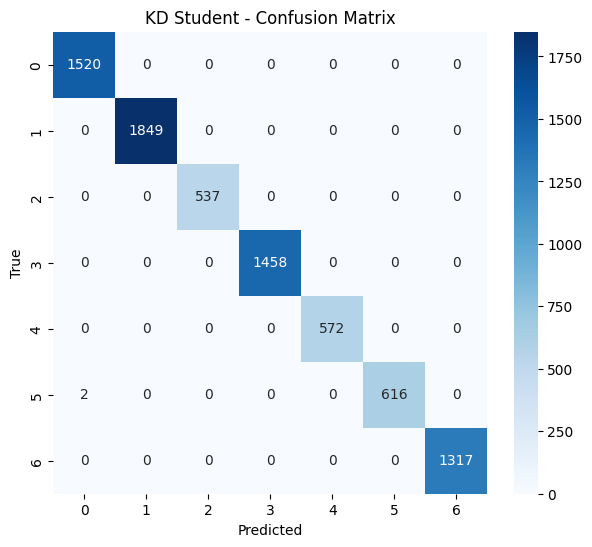

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def evaluate_confusion_matrix(model, loader, class_names=None):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            xb_student = prepare_inputs(xb, model)  # ensure shape
            logits = model(xb_student)
            preds = logits.argmax(1)
            all_preds.append(preds.cpu())
            all_labels.append(yb.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    cm = confusion_matrix(all_labels, all_preds)
    acc = (all_preds == all_labels).mean()
    print(f"Confusion Matrix (overall acc={acc:.4f}):")

    # Plot heatmap
    plt.figure(figsize=(7, 6))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=class_names if class_names else range(cm.shape[0]),
        yticklabels=class_names if class_names else range(cm.shape[0])
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("KD Student - Confusion Matrix")
    plt.show()

    return cm

# --- Run on test set ---
cm_student = evaluate_confusion_matrix(student, test_loader, class_names=student_classes)


In [31]:
import torch.nn.utils.prune as prune
import torch.nn as nn

# --- Collect only Conv2d & Linear layers ---
def collect_prunable_modules(model):
    return [m for m in model.modules() if isinstance(m, (nn.Conv2d, nn.Linear))]

# --- Global L1 pruning ---
def global_l1_prune(model, amount=0.10):
    modules = collect_prunable_modules(model)
    if not modules:
        raise RuntimeError("No Conv2d/Linear layers found to prune.")

    params_to_prune = [(m, "weight") for m in modules]

    prune.global_unstructured(
        params_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=amount
    )

    # Report sparsity
    total, zeros = 0, 0
    for m in modules:
        w = m.weight.detach()   # safely access raw tensor
        total += w.numel()
        zeros += torch.sum(w == 0).item()
    sparsity = zeros / total
    print(f"[Prune] Target={amount:.2%} | Observed sparsity={sparsity:.2%}")
    return sparsity

# --- Remove pruning reparametrization ---
def remove_pruning_reparam(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)) and hasattr(m, "weight_orig"):
            prune.remove(m, "weight")

# --- Apply pruning ---
target_amount = 0.10  # 10%
sparsity = global_l1_prune(student, amount=target_amount)

# --- Fine-tuning after pruning ---
ft_opt = torch.optim.Adam(student.parameters(), lr=5e-4, weight_decay=1e-5)
ft_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(ft_opt, mode="min", patience=6, factor=0.5)

def finetune_after_prune(model, teacher, loader, val_loader, epochs=20):
    best = float("inf")
    best_state = None
    stale = 0
    patience = 10

    for ep in range(1, epochs + 1):
        tr = run_epoch_kd(model, teacher, loader, train=True)
        with torch.no_grad():
            model.eval()
            va = run_epoch_kd(model, teacher, val_loader, train=False)

        ft_sched.step(va["loss"])

        print(f"[FT] Epoch {ep:02d} | "
              f"train loss={tr['loss']:.4f} acc={tr['acc']:.4f} | "
              f"val loss={va['loss']:.4f} acc={va['acc']:.4f}")

        if va["loss"] < best - 1e-4:
            best = va["loss"]
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            stale = 0
        else:
            stale += 1
            if stale >= patience:
                print("Early stop during fine-tuning.")
                break

    if best_state:
        model.load_state_dict(best_state)

# Run short fine-tune
finetune_after_prune(student, teacher, train_loader, val_loader, epochs=5)

# --- Permanently remove pruning masks ---
remove_pruning_reparam(student)
student.eval()


[Prune] Target=10.00% | Observed sparsity=10.00%
[FT] Epoch 01 | train loss=0.0768 acc=0.9977 | val loss=0.0594 acc=0.9997
[FT] Epoch 02 | train loss=0.0774 acc=0.9983 | val loss=0.0607 acc=0.9994
[FT] Epoch 03 | train loss=0.0780 acc=0.9977 | val loss=0.0605 acc=0.9995
[FT] Epoch 04 | train loss=0.0756 acc=0.9983 | val loss=0.0591 acc=1.0000
[FT] Epoch 05 | train loss=0.0745 acc=0.9985 | val loss=0.0676 acc=0.9958


StudentCNN(
  (features): Sequential(
    (0): Conv2d(102, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, di

Student — Test Loss: 0.0713 | Acc: 0.9997
[0] P=0.999 R=1.000 F1=0.999 | N=1520
[1] P=1.000 R=1.000 F1=1.000 | N=1849
[2] P=1.000 R=1.000 F1=1.000 | N=537
[3] P=1.000 R=1.000 F1=1.000 | N=1458
[4] P=1.000 R=1.000 F1=1.000 | N=572
[5] P=1.000 R=0.997 F1=0.998 | N=618
[6] P=1.000 R=1.000 F1=1.000 | N=1317


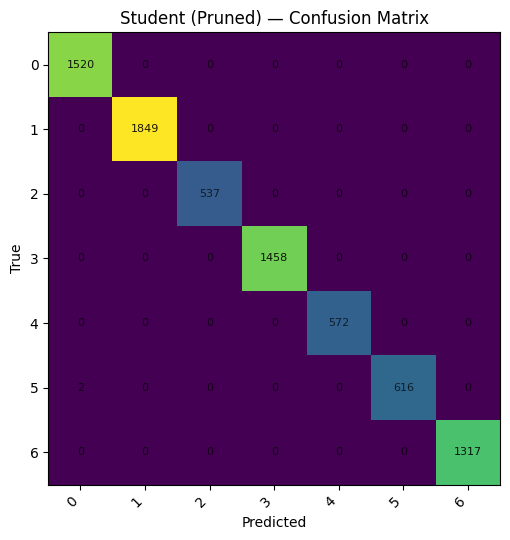

In [32]:
import numpy as np
import matplotlib.pyplot as plt

@torch.no_grad()
def evaluate(model, loader, device=device):
    model.eval()
    total = 0
    correct = 0
    loss_sum = 0.0
    num_classes = model.n_classes
    conf = torch.zeros((num_classes, num_classes), dtype=torch.long, device='cpu')

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        if xb.ndim == 4 and xb.shape[1] not in (1,3,model.in_ch) and xb.shape[-1] == model.in_ch:
            xb = xb.permute(0,3,1,2).contiguous()

        logits = model(xb)
        loss = F.cross_entropy(logits, yb)
        preds = logits.argmax(1)

        loss_sum += loss.item() * xb.size(0)
        total += xb.size(0)
        correct += (preds == yb).sum().item()

        # confusion matrix update
        k = model.n_classes
        idx = yb.to('cpu') * k + preds.to('cpu')
        conf += torch.bincount(idx, minlength=k*k).reshape(k, k)

    acc = correct / max(1, total)
    avg_loss = loss_sum / max(1, total)
    return {'loss': avg_loss, 'acc': acc, 'confusion': conf}

def per_class_metrics(conf, eps=1e-12):
    # conf: [true, pred]
    tp = conf.diag().float()
    fp = conf.sum(0).float() - tp
    fn = conf.sum(1).float() - tp
    precision = tp / (tp + fp + eps)
    recall    = tp / (tp + fn + eps)
    f1        = 2 * precision * recall / (precision + recall + eps)
    support   = conf.sum(1).float()
    return precision, recall, f1, support

def plot_confusion(conf, class_names, title="Confusion Matrix"):
    cm = conf.numpy()
    fig, ax = plt.subplots(figsize=(6.5, 5.5))
    im = ax.imshow(cm, interpolation='nearest')
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.set_yticklabels(class_names)
    # annotate
    vmax = cm.max() if cm.max() > 0 else 1
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, int(cm[i, j]), ha="center", va="center",
                    fontsize=8, alpha=0.9 if cm[i,j] > 0.5*vmax else 0.7)
    fig.tight_layout()
    plt.show()

# Evaluate on test set
test_student = evaluate(student, test_loader, device)
prec, rec, f1, sup = per_class_metrics(test_student['confusion'])
print(f"Student — Test Loss: {test_student['loss']:.4f} | Acc: {test_student['acc']:.4f}")
for i, name in enumerate(student.class_names):
    print(f"[{name}] P={prec[i]:.3f} R={rec[i]:.3f} F1={f1[i]:.3f} | N={int(sup[i].item())}")

plot_confusion(test_student['confusion'], student.class_names, title="Student (Pruned) — Confusion Matrix")


In [66]:
import torch
import torch.nn.utils.prune as prune
import pandas as pd

# --- Utility: count parameters ---
def count_params(model, only_trainable=False):
    if only_trainable:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    return sum(p.numel() for p in model.parameters())

# --- Evaluate helper ---
@torch.no_grad()
def evaluate_model(model, loader, criterion, device):
    model.eval()
    total_loss, total_acc, total_n = 0.0, 0.0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        # adjust input shape depending on model type
        if any(isinstance(m, torch.nn.Conv3d) for m in model.modules()):  # teacher
            if xb.ndim == 4: xb = xb.unsqueeze(1)  # [B, Bands, H, W] → [B,1,Bands,H,W]
        else:  # student / pruned student
            if xb.ndim == 5 and xb.shape[1] == 1: xb = xb.squeeze(1)
        logits = model(xb)
        loss = criterion(logits, yb)
        preds = logits.argmax(1)
        acc = (preds == yb).float().mean().item()
        bs = yb.size(0)
        total_loss += loss.item() * bs
        total_acc  += acc * bs
        total_n    += bs
    return total_loss / max(1,total_n), total_acc / max(1,total_n)

# --- Create pruned student (10% pruning on conv layers) ---
import copy
pruned_student = copy.deepcopy(student)
for name, module in pruned_student.named_modules():
    if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
        prune.l1_unstructured(module, name="weight", amount=0.1)

# --- Models to compare ---
models = {
    "Teacher": trained_teacher,
    "Student (KD)": student,
    "Pruned Student": pruned_student
}

# --- Criterion for eval (plain CE) ---
criterion_eval = torch.nn.CrossEntropyLoss()

# --- Collect results ---
rows = []
for name, model in models.items():
    total_params = count_params(model, only_trainable=False)
    trainable_params = count_params(model, only_trainable=False)
    test_loss, test_acc = evaluate_model(model, test_loader, criterion_eval, device)
    rows.append({
        "Model": name,
        "Total Params": f"{total_params:,}",
        "Trainable Params": f"{trainable_params:,}",
        "Test Loss": f"{test_loss:.2f}",
        "Test Acc": f"{test_acc*100:.2f}%"
    })

# --- Show as DataFrame ---
df = pd.DataFrame(rows)
print("\n=== Teacher vs. Student vs. Pruned Student Comparison ===\n")
print(df.to_string(index=False))



=== Teacher vs. Student vs. Pruned Student Comparison ===

         Model Total Params Trainable Params Test Loss Test Acc
       Teacher    1,291,607        1,291,607      0.13   98.72%
  Student (KD)       67,351           67,351      0.07   99.97%
Pruned Student       67,351           67,351      0.08   99.97%


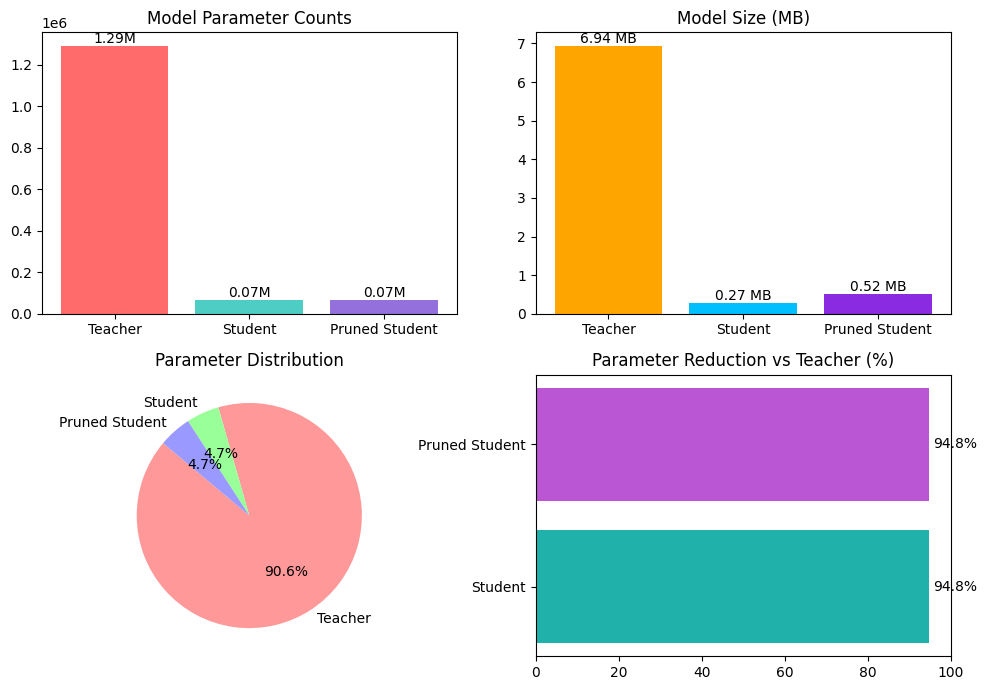

In [68]:
# === Teacher vs Student vs Pruned Student Visualization ===
import torch
import matplotlib.pyplot as plt
import numpy as np
import os

# ===== Utility functions =====
def get_model_size(model):
    torch.save(model.state_dict(), "temp.pth")
    size_mb = os.path.getsize("temp.pth") / (1024 * 1024)
    os.remove("temp.pth")
    return size_mb

def count_parameters(model, trainable_only=False):
    if trainable_only:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    return sum(p.numel() for p in model.parameters())

# ===== Collect stats =====
models = {
    "Teacher": trained_teacher,
    "Student": student,            # <-- your KD student
    "Pruned Student": pruned_student
}

params_total = {name: count_parameters(m, trainable_only=False) for name, m in models.items()}
sizes = {name: get_model_size(m) for name, m in models.items()}

# Relative reductions (vs Teacher)
reductions = {name: (1 - params_total[name] / params_total["Teacher"]) * 100 
              for name in models if name != "Teacher"}

# ===== Visualization =====
fig, axs = plt.subplots(2, 2, figsize=(10, 7))

# 1. Bar Chart: Parameters
axs[0,0].bar(params_total.keys(), params_total.values(), color=["#FF6B6B", "#4ECDC4", "#9370DB"])
axs[0,0].set_title("Model Parameter Counts")
for i, (name, val) in enumerate(params_total.items()):
    axs[0,0].text(i, val, f"{val/1e6:.2f}M", ha="center", va="bottom")

# 2. Bar Chart: Model Sizes
axs[0,1].bar(sizes.keys(), sizes.values(), color=["#FFA500", "#00BFFF", "#8A2BE2"])
axs[0,1].set_title("Model Size (MB)")
for i, (name, val) in enumerate(sizes.items()):
    axs[0,1].text(i, val, f"{val:.2f} MB", ha="center", va="bottom")

# 3. Pie Chart: Parameter Distribution
axs[1,0].pie(params_total.values(), labels=params_total.keys(),
             autopct="%1.1f%%", colors=["#FF9999", "#99FF99", "#9999FF"], startangle=140)
axs[1,0].set_title("Parameter Distribution")

# 4. Reduction Bar (Student + Pruned Student vs Teacher)
axs[1,1].barh(list(reductions.keys()), list(reductions.values()), color=["#20B2AA", "#BA55D3"])
axs[1,1].set_xlim(0, 100)
axs[1,1].set_title("Parameter Reduction vs Teacher (%)")
for i, (name, val) in enumerate(reductions.items()):
    axs[1,1].text(val + 1, i, f"{val:.1f}%", va="center")

plt.tight_layout()
plt.show()


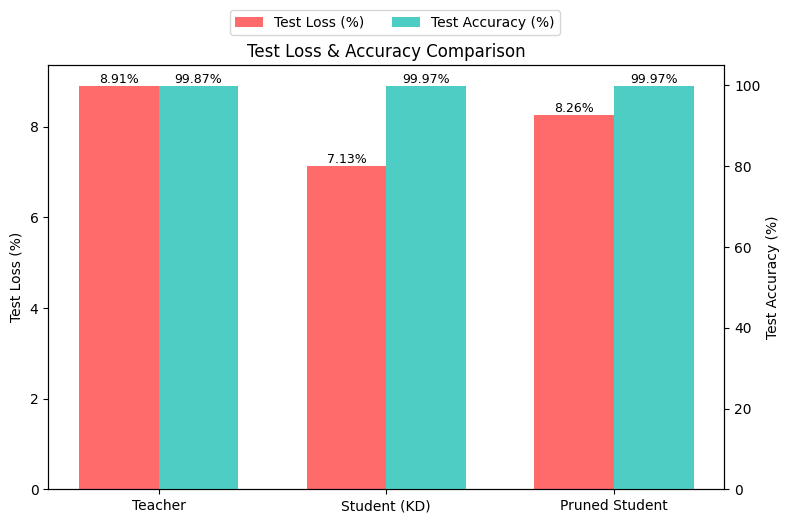

In [69]:
# === Accuracy & Test Loss Comparison (Teacher vs Student vs Pruned Student) ===
import matplotlib.pyplot as plt

# ===== Collected test results =====
results = {
    "Teacher": {
        "Test Loss": 0.0891,
        "Test Acc": 0.9987
    },
    "Student (KD)": {
        "Test Loss": 0.0713,
        "Test Acc": 0.9997
    },
    "Pruned Student": {
        "Test Loss": 0.0826,
        "Test Acc": 0.9997
    }
}

# Convert accuracy to percentage (%)
for model in results:
    results[model]["Test Acc"] = results[model]["Test Acc"] * 100
    results[model]["Test Loss"] = results[model]["Test Loss"] * 100  # for % scale

# ===== Visualization =====
labels = list(results.keys())
test_loss = [results[m]["Test Loss"] for m in labels]
test_acc = [results[m]["Test Acc"] for m in labels]

x = range(len(labels))
width = 0.35

fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot Test Loss (bars, %)
bars1 = ax1.bar([i - width/2 for i in x], test_loss, width, label="Test Loss (%)", color="#FF6B6B")
ax1.set_ylabel("Test Loss (%)")
ax1.set_title("Test Loss & Accuracy Comparison")
ax1.set_xticks(x)
ax1.set_xticklabels(labels)

# Create second axis for accuracy
ax2 = ax1.twinx()
bars2 = ax2.bar([i + width/2 for i in x], test_acc, width, label="Test Accuracy (%)", color="#4ECDC4")
ax2.set_ylabel("Test Accuracy (%)")

# Add value labels on top of bars
for bar in bars1:
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{bar.get_height():.2f}%", 
             ha="center", va="bottom", fontsize=9)

for bar in bars2:
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{bar.get_height():.2f}%", 
             ha="center", va="bottom", fontsize=9)

# Legends
fig.legend(loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.05))

plt.tight_layout()
plt.show()
